In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Concatenate
from IPython import display
from sklearn.model_selection import train_test_split
import glob
import imageio
from compas.datastructures import Mesh
from compas_plotters.meshplotter import MeshPlotter
import networkx 
from networkx.algorithms.components.connected import connected_components
from keras import layers, activations
import os
import pandas as pd
import tensorflow as tf
import random

In [29]:
job_directory=os.getcwd()
data= os.path.join(job_directory, "Data","dense_meshquarter.obj")
meshdense = Mesh.from_obj(data)
Trainning_Dataset_dir= os.path.join(job_directory, "Trainning_Dataset")
feautures_flatten_dir=os.path.join(Trainning_Dataset_dir, "feautures_flatten.npy")
feautures=np.load(feautures_flatten_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [4]:
# Get a mesh from an adjacency matrix
def Mesh_from_mtx(mtx):
    vertices_old = list(meshdense.vertices())
    v_old=[]
    for i in vertices_old:
        i_coordinates_old=Mesh.vertex_coordinates(meshdense, i, axes='xyz')
        v_old.append(i_coordinates_old)

    #get the connected edges
    D=networkx.DiGraph(mtx) 
    edges = [[u, v] for [u, v] in D.edges()]

    #sort the tuples of edges
    temp=[]
    for i in edges:
        temp.append(tuple(sorted(i)))

    #delete duplicate edges
    temp=set(temp) #first create ser

    temp=tuple(temp) #convert set to tuple

    #Convert to list
    edges=[]
    for i in temp:
        z=[]
        for y in i:
            z.append(v_old[y])
        edges.append(z)

    mrebuild=Mesh.from_lines(edges)
    return (mrebuild)

In [6]:
def flatten_to_matrix(flatten_lst,shape1):
    array_zero=np.zeros((shape1,shape1))
    y=0
    for i in range(shape1):
        for e in range(i):
            array_zero[i,e]=flatten_lst[y]
            array_zero[e,i]=flatten_lst[y]
            y=y+1
    array_new=array_zero
    return array_new

In [7]:
#Check if the Generation Exists
def exist(mtx,feautures_flatten):
    ex=0
    for i in range(feautures_flatten.shape[0]):
        A=feautures_flatten[i]
        B=mtx    
        C=(A==B).all()
        if C==1:
            ex=ex+C
    return ex

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            #reconstruction =tf.round(self.decoder(z))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            reconstruction_loss *= 3240
           
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) 
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 

            total_loss = reconstruction_loss + kl_loss 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


    def test_step(self, data):
      if isinstance(data, tuple):
        data = data[0]

      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
            keras.losses.mean_squared_error(data, reconstruction)
      )
      reconstruction_loss *= 81 * 81

      kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      kl_loss = tf.reduce_mean(kl_loss)
      kl_loss *= -0.5
      total_loss = reconstruction_loss + kl_loss

      return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }

In [ ]:
job_directory=os.getcwd()
location= os.path.join(job_directory, "Saved_VAE/")
encoder= keras.models.load_model(location + "encoder_arch") #Loading the encoder model
decoder= keras.models.load_model(location +"decoder_arch") #Loading the decoder model
vae = VAE(encoder, decoder) #You need to have VAE class defined for this to works
vae.get_layer('encoder').load_weights(location + "encoder_weights.h5") #On a given encoder model defined by vae_new we want to load the weights
vae.get_layer('decoder').load_weights(location +"decoder_weights.h5") #for encoder and decoder
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
location_s= os.path.join(job_directory, "Surrogate/")
surrogate= keras.models.load_model(location_s) #Loading the surrogate

In [35]:
#load a case
load_case_dir= os.path.join(job_directory, "Cases","int_665","int_665_lr2.5.npy")
z_ar=np.load(load_case_dir, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
z=tf.convert_to_tensor(z_ar)

for the sample performance is: 0.16579011 int: 999


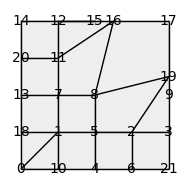

In [36]:
#gradient descent for a loaded case
lst_mtx=[]
lst_perf=[]
lst_gradient=[]
lr=2.5
latent_dim=10
for i in range(1000):#loop for GD interations
    with tf.GradientTape() as tape:
        tape.watch(z)
        decodedtensor=vae.decoder(z)
        decodedtensor= layers.Reshape((1,3240))(decodedtensor)
        y = surrogate(decodedtensor) 
        gradient = tape.gradient(y,z)
    gr_arr=gradient.numpy().reshape(latent_dim)
    rms=np.sqrt(np.mean(gr_arr**2))


    lst_gradient.append(rms)
    yarr=y.numpy()
    yarr=yarr.reshape(1)    
    lst_perf.append(yarr[0])

              
    decodedtensor=vae.decoder(z)
    decodedtensor=tf.round(decodedtensor)
    decodedarray=decodedtensor.numpy().reshape((3240))        
    mtx=flatten_to_matrix(decodedarray,81)
    z=z-(lr*gradient) 
    lst_mtx.append(mtx)

        
print ("for the sample performance is:",yarr[0],"int:",i)
testmesh= Mesh_from_mtx(mtx)
plotter = MeshPlotter(testmesh, figsize=(2, 2))
plotter.draw_edges()
plotter.draw_vertices(text='key', radius=0.01)
plotter.draw_faces()
plotter.show() 

In [ ]:
#Run the Gradient Descent for the Database
lr=2.5
lst_z=[]
lst_mtx=[]
lst_perf=[]

for e in range(3619): #loop for all the samples
    test_mesh=feautures[e]
    
    test_mesh= test_mesh.astype('float32')
    test_mesh=test_mesh.reshape((1,3240))
    x= vae.encoder(test_mesh)
    z0=x[2]
    z=z0
    temp_lst=[]
    for i in range(100):#loop for GD interations
        with tf.GradientTape() as tape:
            tape.watch(z)
            decodedtensor=vae.decoder(z)
            decodedtensor= layers.Reshape((1,3240))(decodedtensor)
            y = surrogate(decodedtensor) 
            gradient = tape.gradient(y,z)
        yarr=y.numpy()
        yarr=yarr.reshape(1)                
        decodedtensor=vae.decoder(z)
        decodedtensor=tf.round(decodedtensor)
        decodedarray=decodedtensor.numpy().reshape((3240))        
        mtx=flatten_to_matrix(decodedarray,81)
        z=z-(lr*gradient) 

    if yarr[0]<0.26 and exist(decodedarray,feautures)==0: #if estimated performance <0.19            
        print (z0)
        lst_z.append(z0)
        lst_mtx.append(mtx)
        lst_perf.append(yarr[0])
        print ("for the sample:",(e),"for which z=" ,z0,"performance was:",yarr[0])
        testmesh= Mesh_from_mtx(mtx)
        plotter = MeshPlotter(testmesh, figsize=(2, 2))
        plotter.draw_edges()
        plotter.draw_vertices(text='key', radius=0.01)
        plotter.draw_faces()
        plotter.show() 